In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Verified Neural System Identification and Control

This notebook contains some exploratory code, directed towards the problem of 

1. learning the dynamics of a discrete-time dynamical system,
2. learning (simultaneously) a stabilizing controller for the system and a Lyapunov stability certificate, and
3. verifying that the Lyapunov property holds despite some bounded error in system identification

## Theory

Consider a discrete-time dynamical system $x_{t+1} = f(x_t, u_t)$, where $x \in \mathcal{X} \subset \mathbb{R}^n$ and $u \in \mathcal{U} \subset \mathbb{R}^m$, equipped with a feedback controller $u = \pi(x)$. This gives us the closed-loop dynamics $$x_{t+1} = f(x_t, \pi(x_t)) = f_\pi(x_t)$$

Assume the closed-loop system has a fixed point $x^*$ such that $f_\pi(x^*) = x^*$. Let $V(x): \mathbb{R}^n \to \mathbb{R}$. Then the closed loop system will be asymptotically stable at $x^*$ if the following hold:

1. $V(x^*) = 0$
2. $V(x) > 0;\quad \forall x \in (\mathcal{X} - x^*)$
3. $V(x_{t+1}) - V(x_t) < 0;\quad \forall x \in (\mathcal{X} - x^*)$

We can also express (3) in terms of the closed-loop dynamics: $V\circ f_\pi(x_t) - V(x_t) < 0$.

## Approach

We will approach this problem in three steps.

1. First, we will learn the open-loop system dynamics $f(x, u)$ from trajectories, using a neural network with ReLU activations.
2. Next, we will fix the learned dynamics and simultaneously learn a controller $\pi(x)$ and Lyapunov function $V(x)$, using a loss that guides us towards satisfying conditions (1)-(3) above.
3. Finally, we will verify that conditions (2) and (3) hold throughout the domain.

## Step 1: Learn dynamics from trajectories

We'll use a two-link pendulum with actuation only at the elbow (i.e. an acrobot) as our example system for this problem (this is a challenging control problem, so maybe we downgrade to a simple inverted pendulum if it's too hard).

In [139]:
# Start by building an oracle for the system dynamics. This will be used to generate training trajectories
def f_true(x, u):
    """Acrobot discrete-time dynamics.
    Source: http://underactuated.mit.edu/acrobot.html#section1
    """
    # Define parameters
    dt = 0.01  # timestep
    g = 9.81   # gravitational acceleration
    l1 = 1     # Length of link 1
    lc1 = 0.5  # Distance from pivot to link 1 center of mass
    m1 = 0.5   # Mass of link 1
    I1 = 1     # Rotational inertia of link 1
    lc2 = 0.5  # Distance from joint to link 2 center of mass
    m2 = 0.5   # Mass of link 2
    I2 = 1     # Rotational inertia of link 2
    
    # Unpack state variables
    assert x.shape == (4, 1)
    assert u.shape == (1, 1)
    q1 = x[0, 0]      # angle of link 1 w.r.t. vertical
    q2 = x[1, 0]      # angle of link 2 w.r.t. link 1
    q1_dot = x[2, 0]  # link 1 angular velocity
    q2_dot = x[3, 0]  # link 2 angular velocity
    
    # Construct manipulator equation matrices
    # Mass matrix
    M = np.array([
        [I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*np.cos(q2), I2 + m2*l1*lc2*np.cos(q2)],
        [I2 + m2*l1*lc2*np.cos(q2), I2]
    ])
    # Coriolis/damping matrix
    C = np.array([
        [-2*m2*l1*lc2*np.sin(q2)*q2_dot, -m2*l1*lc2*np.sin(q2)],
        [m2*l1*lc2*np.sin(q2)*q1_dot, 0]
    ])
    # Gravitational torque
    tau_g = np.array([
        [-m1*g*lc1*np.sin(q1) - m2*g*(l1*np.sin(q1) + lc2*np.sin(q1+q2))],
        [-m2*g*lc2*np.sin(q1+q2)]
    ])
    # Actuation matrix
    B = np.array([
        [0],
        [1]
    ])
    
    # Now we can construct the derivatives
    xdot = np.zeros(x.shape)
    # First derivatives of q1 and q2 are q1_dot and q2_dot, respectively
    xdot[0, 0] = q1_dot
    xdot[1, 0] = q2_dot
    # Angular accelerations are given by a slightly more annoying formula
    # source: http://underactuated.mit.edu/intro.html#section2
    xdot[2:, :] = np.linalg.inv(M) @ (tau_g + B @ u - C @ x[2:, :])
    
    # Apply a simple euler integration to advance the dynamics
    new_x = np.copy(x)
    new_x += xdot * dt
    
    return new_x


In [244]:
# Gather training and test data by running a bunch of trajectories.
# We'll use the test data to characterize the error in the learned dynamics.
N_train = 1
N_test = 1

def gather_trajectory_data(N, T, x_min, x_max, u_max):
    """Simulate N random trajectories for a fixed number of steps.
    
    args:
        N - the number of trajectories to generate
        T - the length of each trajectory
        x_min/x_max - define a bounding box on initial conditions
        u_max - Maximum amplitude of control inputs
    returns
        a (N x T x 4) numpy array of the trajectories and a (N x 1) numpy array of control inputs
    """
    trajectories = np.zeros((N, T, 4))
    controls = np.zeros((N, T))
    
    # To ensure persistent excitation, we generate control inputs as a random mix of sinusoids
    frequencies = 2*np.pi / T * np.arange(0, T)
    timesteps = np.arange(0, T)
    control_basis = np.cos(frequencies.reshape((T, 1)) * timesteps)
    
    # Create each trajectory by simulating with random control inputs from a random starting state
    for i in tqdm(range(N)):
        control_weighting = np.random.rand(T).reshape((1, T))
        control_input = control_weighting @ control_basis
        control_input *= u_max / np.max(control_input)
        controls[i, :] = control_input
        
        trajectories[i, 0, :] = np.random.uniform(x_min, x_max).reshape((4,))
        
        # Simulate!
        for t in range(T-1):
            x = trajectories[i, t, :].reshape((4, 1))
            u = control_input[0, t].reshape((1, 1))
            trajectories[i, t+1, :] = f_true(x, u).reshape((4,))
    
    return trajectories, controls


x_min = np.zeros((4, 1))
x_min[0, 0] = -np.pi
x_min[1, 0] = -np.pi
x_min[2, 0] = -2*np.pi
x_min[3, 0] = -2*np.pi
x_max = -1 * x_min
u_max = 2
T = 1000  # discretized with dt = 0.01, so this is a 10-second trajectory
print("Gathering training data...")
training_trajectories, training_controls = gather_trajectory_data(N_train, T, x_min, x_max, u_max)
print("Gathering test data...")
test_trajectories, test_controls = gather_trajectory_data(N_test, T, x_min, x_max, u_max)

Gathering training data...



Gathering test data...


In [245]:
# Convert trajectories to torch tensors
training_trajectories_torch = torch.from_numpy(training_trajectories).float()
training_controls_torch = torch.from_numpy(training_controls).float()
test_trajectories_torch = torch.from_numpy(test_trajectories).float()
test_controls_torch = torch.from_numpy(test_controls).float()

In [256]:
# Define the network for learning the dynamics
n_hidden_layers = 8
hidden_layer_size = 8

n_dims = 4
n_controls = 1

layers = []
# Input layer: inputs are states and controls, outputs are hidden layer activations
input_layer = [nn.Linear(n_dims + n_controls, hidden_layer_size), nn.ReLU()]
layers = layers + input_layer
# Hidden layers: inputs and outputs are the same size
for i in range(n_hidden_layers - 1):
    hidden_layer = [nn.Linear(hidden_layer_size, hidden_layer_size), nn.ReLU()]
    layers = layers + hidden_layer
# Output layer: outputs new states
layers = layers + [nn.Linear(hidden_layer_size, n_dims)]

# Build the network from these components
dynamics_model = nn.Sequential(*layers)
dynamics_model

# Train the dynamics model!

# Define hyperparameters for the learning process
learning_rate = 0.001
momentum = 0.1
min_epochs = 15
max_epochs = 8000
max_test_loss_increases = 3

# Define the loss function
loss_fn = nn.MSELoss()

# Train the IK network
optimizer = optim.SGD(dynamics_model.parameters(), lr=learning_rate, momentum=momentum)

# Keep track of test set loss for early stopping
prev_best_test_set_loss = np.inf
test_loss_increases = 0

# Also log histories of training and test loss
training_losses = []
test_losses = []

for epoch in tqdm(range(max_epochs)):
    
    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)
    
    loss_acumulated = 0.0
    for i in range(0, N_train):
        # For each trajectory, create the pairs of (xt, ut) and x_{t+1}
        trajectory = training_trajectories_torch[i, :T-1, :]
        controls = training_controls_torch[i, :T-1].reshape(T-1, 1)
        inputs = torch.cat([trajectory, controls], 1)
        x_next = training_trajectories_torch[i, 1:, :]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        x_next_predicted = dynamics_model(inputs)
        
        # Compute loss based on mean squared difference in next state
        loss = loss_fn(x_next_predicted, x_next)
        loss_acumulated += loss.item()
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    # save progress
    training_losses.append(loss_acumulated / N_train)
    
    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Accumulate loss from each trajectory in the test set
        for i in range(0, N_test):
            # For each trajectory, create the pairs of (xt, ut) and x_{t+1}
            trajectory = test_trajectories_torch[i, :T-1, :]
            controls = test_controls_torch[i, :T-1].reshape(T-1, 1)
            inputs = torch.cat([trajectory, controls], 1)
            x_next = test_trajectories_torch[i, 1:, :]
            
            x_next_predicted = dynamics_model(inputs)

            loss = loss_fn(x_next_predicted, x_next)
            loss_acumulated += loss
        
        loss = loss_acumulated / N_test
        test_losses.append(loss)

#         if epoch > min_epochs and loss > prev_best_test_set_loss:
#             print(f"Test loss increased on this epoch ({epoch}).")
#             test_loss_increases += 1
#             if test_loss_increases >= max_test_loss_increases:
#                 print("Too many increases. Stopping early.")
# #                 break
#         if loss < prev_best_test_set_loss:
#             prev_best_test_set_loss = loss
#             test_loss_increases = 0

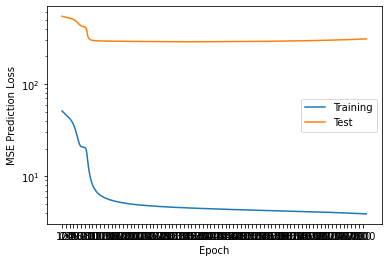

In [257]:
# Plot the loss curves
plt.plot(range(epoch+1), training_losses)
plt.plot(range(epoch+1), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("MSE Prediction Loss")
plt.legend(["Training", "Test"])
plt.yscale("log")

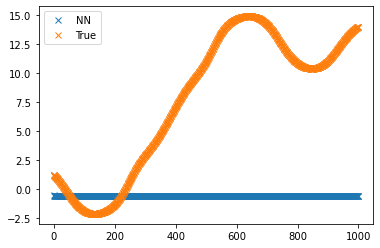

In [258]:
# Now we can see how good these prediction are by trying to recreate the first trajectory
controls = training_controls_torch[0, :].reshape(T, 1)
true_trajectory = training_trajectories_torch[0, :, :]
recreated_trajectory = torch.zeros_like(true_trajectory)
recreated_trajectory[0, :] = true_trajectory[0, :]

with torch.no_grad():
    for t in range(1, T):
        u = controls[t-1, :].reshape(1, 1)
        x = recreated_trajectory[t-1, :].reshape(4, 1)
        inputs = torch.cat([x, u], 0).reshape(1, 1, 5)
        x_next = dynamics_model(inputs)
        recreated_trajectory[t, :] = x_next

plt.plot(range(T), recreated_trajectory[:, 0], 'x')
plt.plot(range(T), true_trajectory[:, 0], 'x')
plt.legend(["NN", "True"])